# Step 5: Analyze final Barnacle model

Use this notebook to compile and analyze the final version of your Barnacle model. This should be the version of the model that is fit with the optimal parameters you identified in step 4. There are several parts of this compilation and analysis notebook:
1. Align the components between bootstraps of your final model.
    - The order of components is not fixed in this tensor decomposition model. Therefore, in order to compare between bootstraps, the components must first be aligned to one another.
    - The aligned bootstraps will be saved as an xarray.DataSet so that you can access them for further analysis
1. Summarize the model weights for each component.
    - Each component can be understood to model a different pattern in the data. Depending on how you set up your data and your Barnacle model, each pattern might also be associated with a different cluster (e.g. gene clusters). This step separates out each component so you can more closely examine the pattern and/or cluster each is modeling.
1. Visualize your model.
    - Effective visualization depends on your data type, size, dimensions, and the questions you are asking. A few potential visualizations are suggested below to help get you started.

In [1]:
# imports

import itertools
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorly as tl
import tlviz
import xarray as xr

from barnacle.tensors import SparseCPTensor
from barnacle.utils import subset_cp_tensor
from functools import reduce
from matplotlib import pyplot as plt
from tlab.cp_tensor import load_cp_tensor
from tqdm.notebook import tqdm

# set color palette
sns.set_palette(sns.color_palette([
    '#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7'
]))


### Part A: Align model bootstraps

In [2]:
# USER INPUTS -- edit these variables as needed

# path to directory where the outputs from your parameter search were saved (e.g. 'directory/barnacle/fitting/')
fitpath = 'data/barnacle/fitting'

# path to the normalized data tensor used to fit barnacle (e.g. 'directory/data-tensor.nc')
datapath = 'data/data-tensor.nc'

# optimal rank parameter (number of components) used to fit your final model
optimal_rank = 5

# optimal lambda parameter (sparsity coefficient) used to fit your final model
optimal_lambda = 1.0

# number of bootstraps used for final model
n_bootstraps = 100

# output directory where files produced by this notebook will be saved
outdir = fitpath.strip('fitting') + 'model'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
print(f"File outputs of this notebook will be saved here: {outdir}")


File outputs of this notebook will be saved here: data/barnacle/model


In [3]:
# align bootstraps of final model

# set up parameters and data structures
input_ds = xr.load_dataset(f"{fitpath}/bootstrap0/dataset-bootstrap0.nc")
replicates = [str(l) for l in set(input_ds.replicate_id.data)]
bootstraps = np.arange(n_bootstraps)
samplenames = {rep: [] for rep in replicates}    # sample names
cps = {rep: [] for rep in replicates}   # cp tensors with all samples present
subset_cps = {rep: [] for rep in replicates}    # cp tensors subset to just common samples

# collect sample names of each bootstrap/replicate pair
for boot in tqdm(bootstraps, desc='Extracting sample names'):
    for rep in replicates:
        ds = xr.open_dataset(f"{fitpath}/bootstrap{boot}/replicate{rep}/shuffled-replicate-{rep}.nc")
        samplenames[rep].append(ds.sample_id.data)
# compile set of samplenames common to all bootstrap / replicate splits
samplenames['common'] = reduce(np.intersect1d, itertools.chain.from_iterable([samplenames[r] for r in replicates]))

# import all fitted models
for boot in tqdm(bootstraps, desc='Importing model bootstraps'):
    for rep in replicates:
        # put together data path
        path_cp = f"bootstrap{boot}/replicate{rep}/rank{optimal_rank}/lambda{optimal_lambda}/fitted-model.h5"
        # store normalized cp tensor to cps
        cp = tl.cp_normalize(load_cp_tensor(f"{fitpath}/{path_cp}"))
        cps[rep].append(cp)
        # pull out common samplenames and store in subset_aligned_cps
        idx = np.where(np.isin(samplenames[rep][boot], samplenames['common']))[0]
        subset_cps[rep].append(subset_cp_tensor(cp, {2: idx}))
print(f"Successfully imported {len(cps[rep])} model bootstraps, each with {len(replicates)} replicates.")

# find best representative reference cp tensor
results = []
combos = list(itertools.product(replicates, bootstraps))
for ref_rep, ref_boot in tqdm(combos, desc='Identifying best reference model from bootstraps'):
    # limit comparisons to a random sample of 100 bootstraps
    if len(combos) > 100:
        combos = [combos[i] for i in np.random.choice(len(combos), size=100, replace=False)]
    for comp_rep, comp_boot in combos:
        # no point in comparing to self
        if ref_rep == comp_rep and ref_boot == comp_boot:
            continue
        reference_cp = subset_cps[ref_rep][ref_boot]
        comparison_cp = subset_cps[comp_rep][comp_boot]
        fms = tlviz.factor_tools.factor_match_score(reference_cp, comparison_cp, consider_weights=False)
        results.append({
            'reference_bootstrap': ref_boot, 
            'reference_replicate': ref_rep, 
            'comparison_bootstrap': comp_boot, 
            'comparison_replicate': comp_rep, 
            'fms': fms, 
        })
# summarize overall mean fms  
fms_df = pd.DataFrame(results)
fms_summary_df = fms_df.groupby([
    'reference_bootstrap', 
    'reference_replicate'
]).agg(
    mean_fms=('fms', 'mean'), 
    median_fms=('fms', 'median'), 
).reset_index()
# find the best representative bootstrap model based on maximum mean FMS
best_ref = fms_summary_df.iloc[fms_summary_df.mean_fms.idxmax(), :]
print('All bootstraps will be aligned to the following reference model:')
display(pd.DataFrame(best_ref).T.reset_index(drop=True))

# permute reference cp so that components are in descending order of explaned variation
ref_cp = tlviz.factor_tools.permute_cp_tensor(
    subset_cps[best_ref['reference_replicate']][best_ref['reference_bootstrap']], 
    consider_weights=False
)        

# realign all the other cp tensors against the best representative cp tensor
for rep in replicates:
    for boot in bootstraps:
        # permute components to line up with best representative reference cp
        perm = tlviz.factor_tools.get_cp_permutation(subset_cps[rep][boot], reference_cp_tensor=ref_cp, consider_weights=False)
        cps[rep][boot] = tlviz.factor_tools.permute_cp_tensor(cps[rep][boot], permutation=perm)
        subset_cps[rep][boot] = tlviz.factor_tools.permute_cp_tensor(subset_cps[rep][boot], permutation=perm)
print('All model bootstraps successfully aligned.')


Extracting sample names:   0%|          | 0/100 [00:00<?, ?it/s]

Importing model bootstraps:   0%|          | 0/100 [00:00<?, ?it/s]

Successfully imported 100 model bootstraps, each with 3 replicates.


Identifying best reference model from bootstraps:   0%|          | 0/300 [00:00<?, ?it/s]

All bootstraps will be aligned to the following reference model:


,reference_bootstrap,reference_replicate,mean_fms,median_fms
0,56,C,0.650567,0.670407


All model bootstraps successfully aligned.


In [4]:
# compile aligned model weights into a single xarray.Dataset

# set up data structures
component_labels = np.arange(optimal_rank) + 1 # 1-based indexing for ease of communication
weights = {'mode0': [], 'mode1': [], 'component': [], 'pct_var': []}
sample_info_df = pd.merge(
    input_ds.sample_id.to_series().reset_index(), 
    input_ds.replicate_id.to_series().reset_index(), 
    on='sample_replicate_id', how='inner'
)[['sample_id', 'replicate_id']].rename(columns={'sample_id': 'sample', 'replicate_id': 'replicate'})
sample_df = pd.DataFrame()

# pull model weights from each bootstrap
for boot in tqdm(bootstraps, desc='Compiling weights from each bootstrap'):
    boot_sample_df = pd.DataFrame()
    for key in weights.keys():
        weights[key].append([])
    for rep in replicates:
        # fetch aligned cp tensor
        cp = cps[rep][boot]
        # add mode 0 weights to list
        weights['mode0'][boot].append(cp.factors[0].T)
        # add mode 1 weights to list
        weights['mode1'][boot].append(cp.factors[1].T)
        # add component weights to list
        weights['component'][boot].append(cp.weights)
        # calculate percent variation explained by components and add to list
        weights['pct_var'][boot].append(tlviz.factor_tools.percentage_variation(cp, dataset=input_ds.data.data, method='data'))
        # put mode 2 (sample) weights into a pd.DataFrame
        rep_sample_df = pd.DataFrame(
            cp.factors[2], index=samplenames[rep][boot], columns=component_labels
        ).reset_index().rename(columns={'index': 'sample'})
        rep_sample_df['replicate'] = rep
        # concatenate sample weights of all replicates
        boot_sample_df = pd.concat([boot_sample_df, rep_sample_df])
    # merge sample info into sample weights dataframe
    boot_sample_df = pd.merge(left=sample_info_df, right=boot_sample_df, on=['sample', 'replicate'], how='left')
    boot_sample_df['bootstrap'] = boot
    # concatenate sample weights of all bootstraps
    sample_df = pd.concat([sample_df, boot_sample_df])

# compile everything into an xarray.Dataset
modes = list(input_ds.coords)
modes[2] = 'sample'
ds = xr.Dataset({
    f"{modes[0]}_weights": xr.DataArray(
        np.array(weights['mode0']), 
        coords=[bootstraps, replicates, component_labels, input_ds[modes[0]].data], 
        dims=['bootstrap', 'replicate', 'component', modes[0]]
    ), 
    f"{modes[1]}_weights": xr.DataArray(
        np.array(weights['mode1']), 
        coords=[bootstraps, replicates, component_labels, input_ds[modes[1]].data], 
        dims=['bootstrap', 'replicate', 'component', modes[1]]
    ), 
    f"{modes[2]}_weights": xr.DataArray.from_series(
        sample_df.melt(
            id_vars=['bootstrap', 'replicate', modes[2]], 
            value_vars=component_labels, 
            var_name='component', 
            value_name='sample_weights'
        ).set_index(['bootstrap', 'replicate', 'component', modes[2]])[f"{modes[2]}_weights"]
    ), 
    'component_weights': xr.DataArray(
            np.array(weights['component']), 
            coords=[bootstraps, replicates, component_labels], 
            dims=['bootstrap', 'replicate', 'component']
    ),
    'percent_variation': xr.DataArray(
            np.array(weights['pct_var']), 
            coords=[bootstraps, replicates, component_labels], 
            dims=['bootstrap', 'replicate', 'component']
    )
})

# add reference tensor, rank, and sparsity coefficient as attributes
ds.attrs['rank'] = optimal_rank
ds.attrs['lambda'] = optimal_lambda
ds.attrs['n_bootstraps'] = n_bootstraps
ds.attrs['align_ref_bootstrap'] = best_ref['reference_bootstrap']
ds.attrs['align_ref_replicate'] = best_ref['reference_replicate']

# save Dataset as netCDF4 file
ds.to_netcdf(f"{outdir}/aligned-bootstraps.nc")

# examine Dataset
ds

Compiling weights from each bootstrap:   0%|          | 0/100 [00:00<?, ?it/s]

<xarray.Dataset> Size: 243MB
Dimensions:            (bootstrap: 100, replicate: 3, component: 5,
                        KOfam: 20069, phylum: 99, sample: 11)
Coordinates:
  * bootstrap          (bootstrap) int64 800B 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * replicate          (replicate) object 24B 'A' 'B' 'C'
  * component          (component) int64 40B 1 2 3 4 5
  * KOfam              (KOfam) <U6 482kB 'K00001' 'K00002' ... 'K26180' 'K26182'
  * phylum             (phylum) <U30 12kB 'Acidobacteriota' ... 'Xanthophyceae'
  * sample             (sample) object 88B 'G3.UW.ALL.L25S1' ... 'G3.UW.ALL.L...
Data variables:
    KOfam_weights      (bootstrap, replicate, component, KOfam) float64 241MB ...
    phylum_weights     (bootstrap, replicate, component, phylum) float64 1MB ...
    sample_weights     (bootstrap, replicate, component, sample) float64 132kB ...
    component_weights  (bootstrap, replicate, component) float64 12kB 160.3 ....
    percent_variation  (bootstrap, replicate, component) float64 12kB 0.4193 ...
Attributes:
    rank:                 5
    lambda:               1.0
    n_bootstraps:         100
    align_ref_bootstrap:  56
    align_ref_replicate:  C

### Part B: Summarize model weights for each component

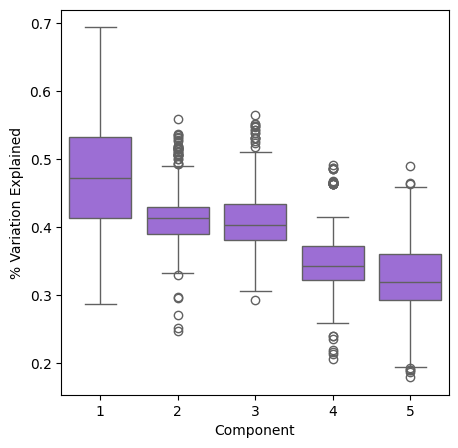


Component 1:



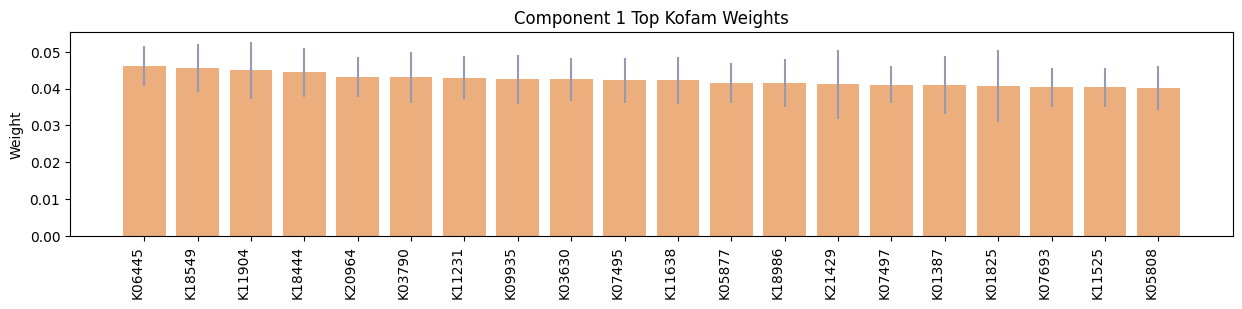

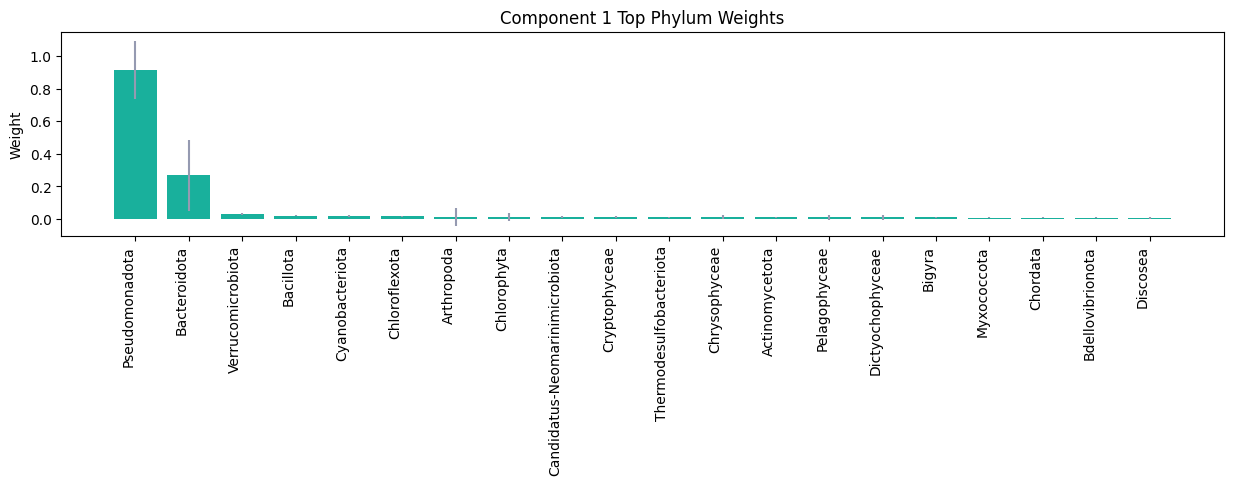

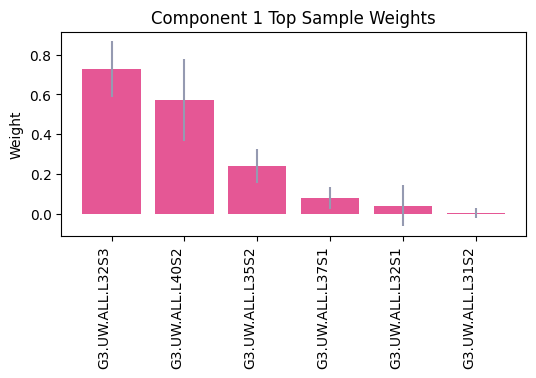


Component 2:



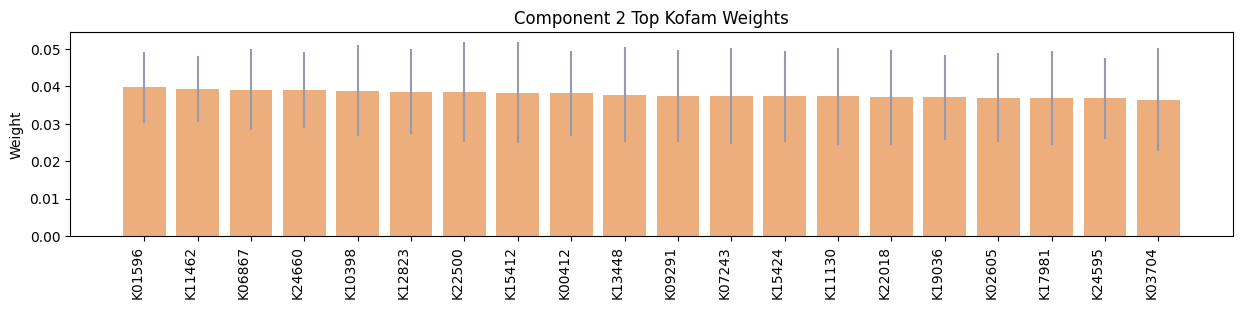

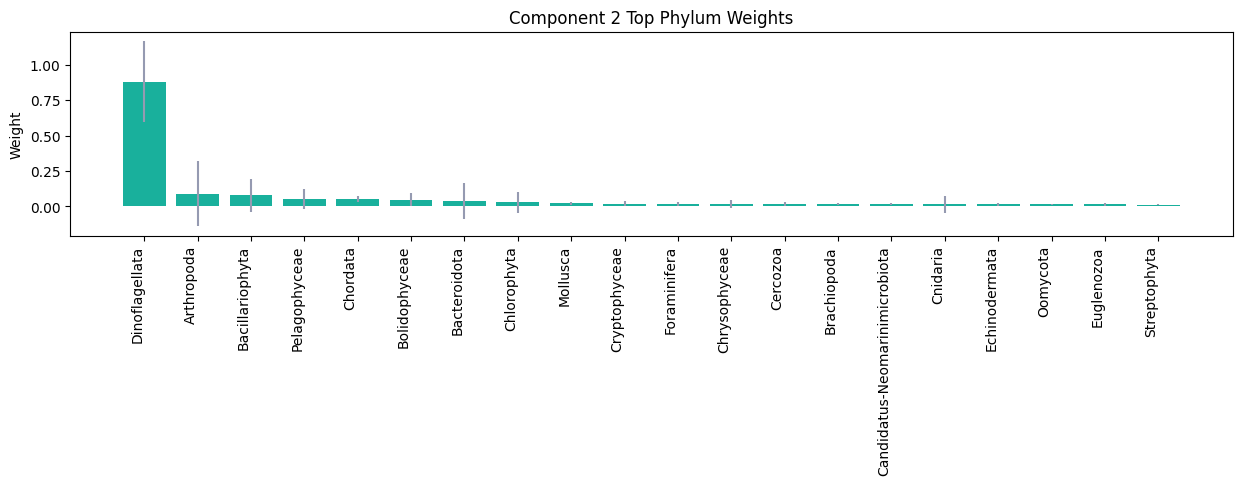

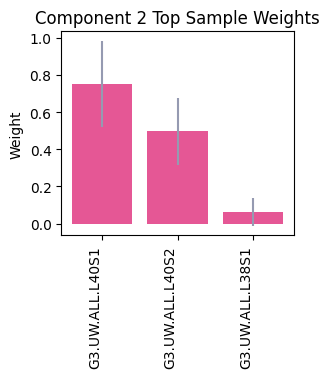


Component 3:



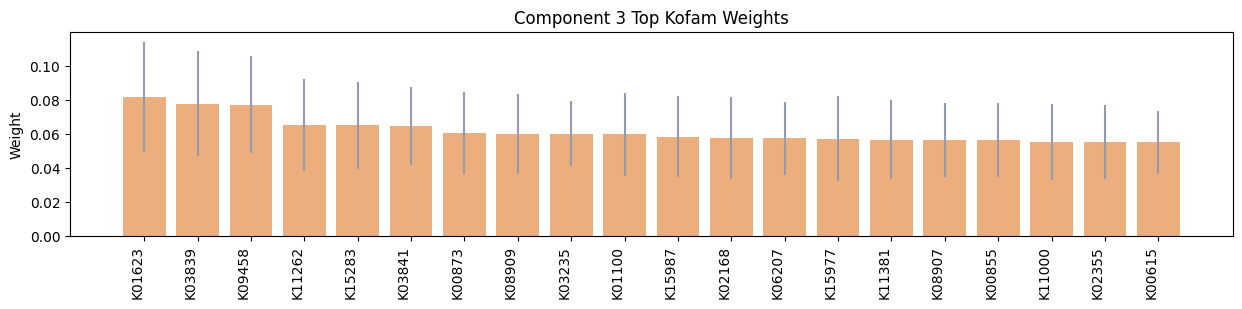

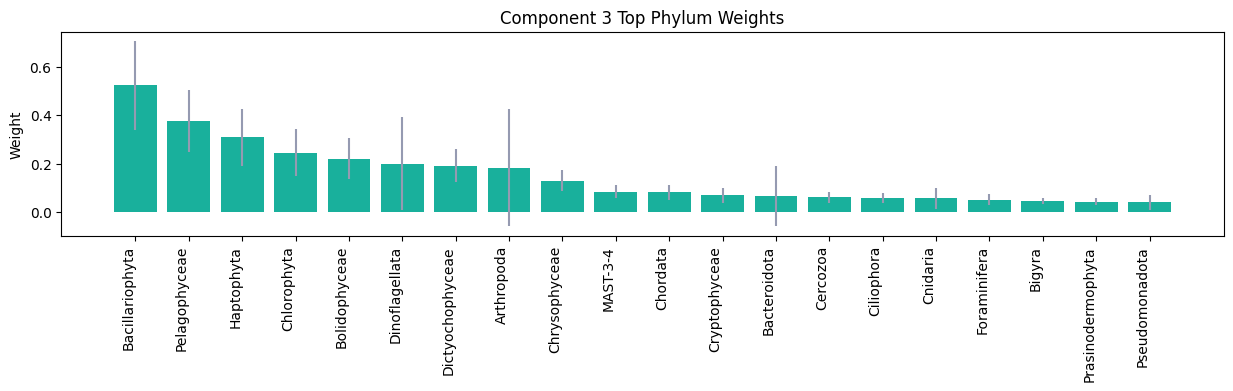

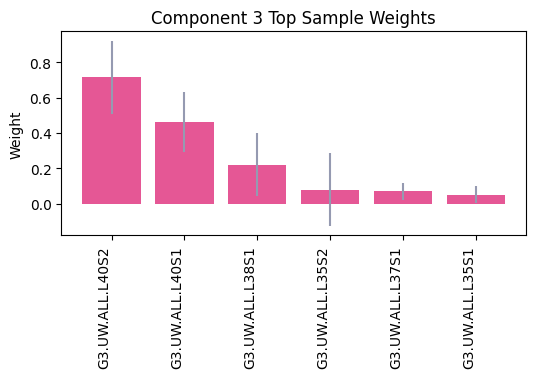


Component 4:



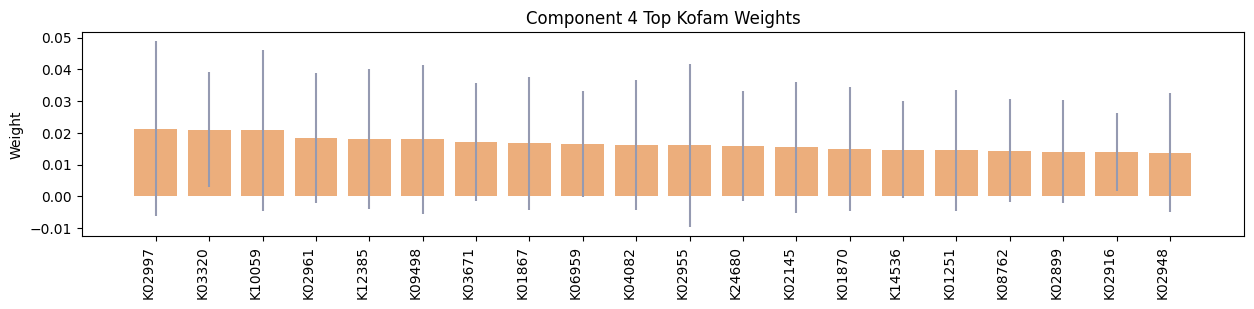

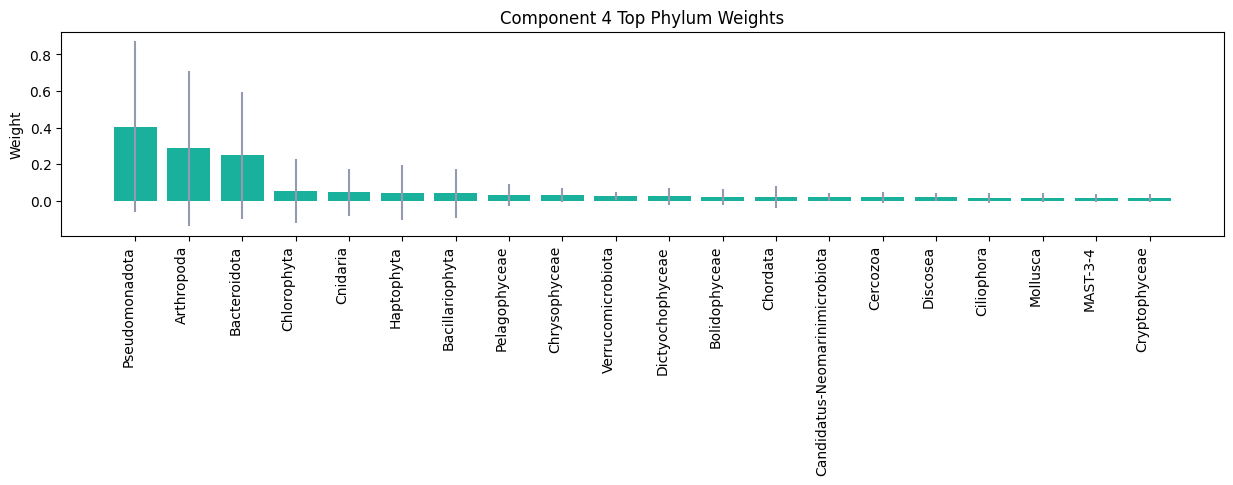

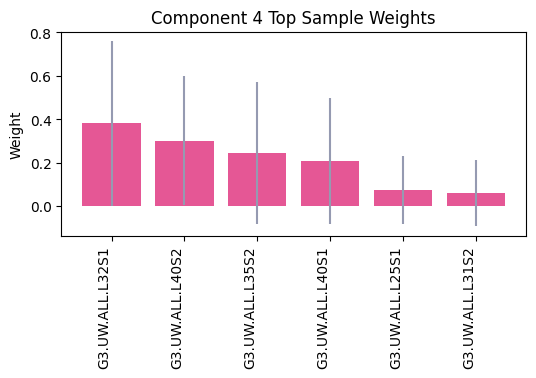


Component 5:



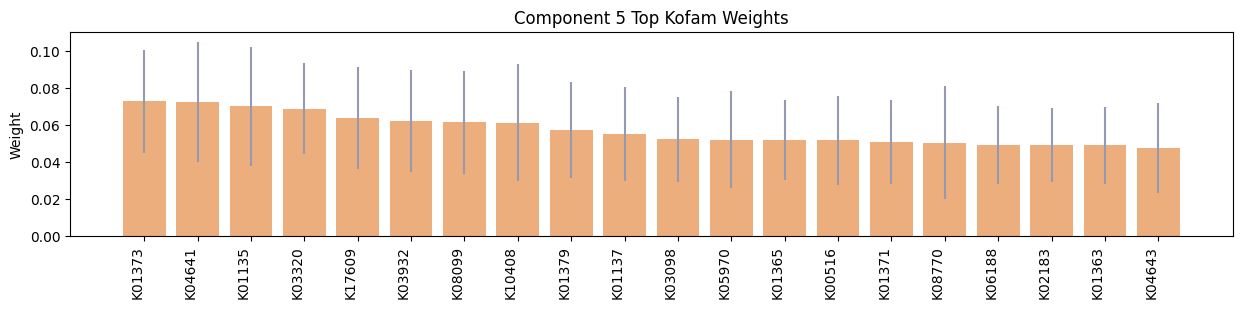

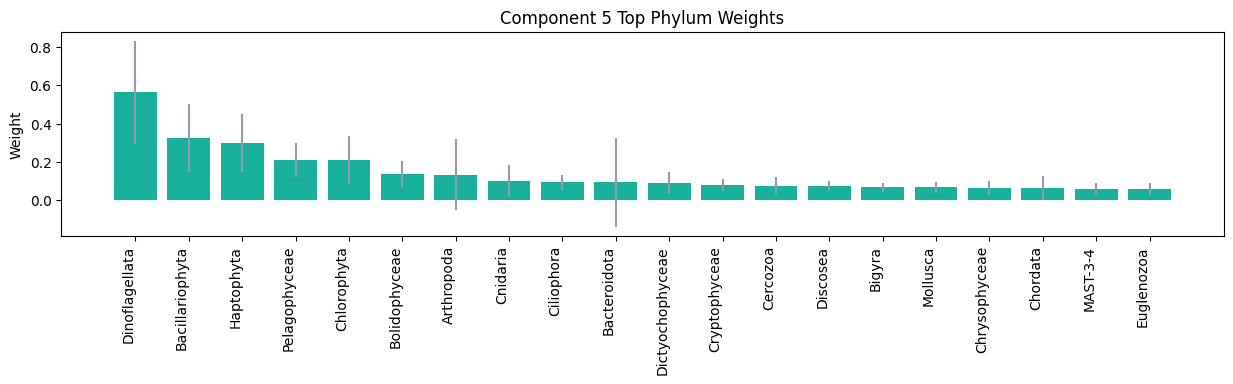

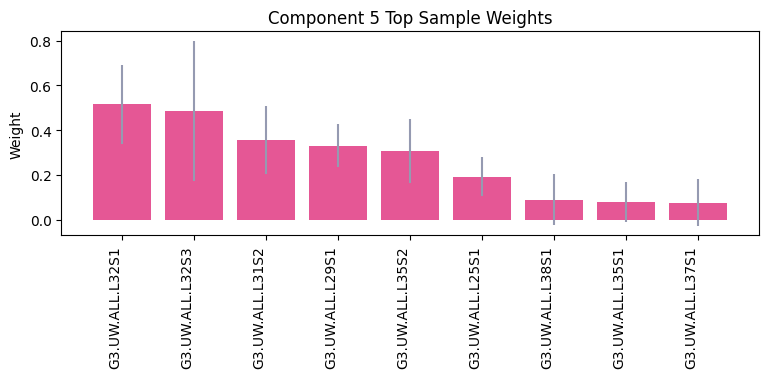

In [5]:
# summarize model weights for each component, and save summaries as csv files

# set max elements to show in visualizations
max_elements = 20

# summarize weights across bootstraps and replicates
mean_ds = ds.mean(dim=['bootstrap', 'replicate'])    # mean of weights
std_ds = ds.std(dim=['bootstrap', 'replicate'])    # standard deviation of weights
med_ds = ds.median(dim=['bootstrap', 'replicate'])    # median of weights
support_ds = (ds != 0).mean(dim=['bootstrap', 'replicate']) * 100     # bootstrap support (percent of weights nonzero)

# plot relative contribution of components
fig, axis = plt.subplots(figsize=(min(15, len(ds.component.data)), 5))
sns.boxplot(ds.percent_variation.to_series().reset_index(), x='component', y='percent_variation', ax=axis); 
axis.set(xlabel='Component', ylabel='% Variation Explained'); 
plt.show()

# extract summary of weights for each component
for component in ds.component.data:
    print(f"\nComponent {component}:\n")
    if not os.path.isdir(f"{outdir}/component{component}"):
        os.makedirs(f"{outdir}/component{component}")
    for i, mode in enumerate(modes):
        # make dataframe summarizing weights
        df = pd.DataFrame({
            'mean_weight': mean_ds.sel(component=component)[f"{mode}_weights"].to_series(), 
            'std_weight': std_ds.sel(component=component)[f"{mode}_weights"].to_series(), 
            'median_weight': med_ds.sel(component=component)[f"{mode}_weights"].to_series(), 
            'pct_bootstraps_nonzero': support_ds.sel(component=component)[f"{mode}_weights"].to_series(), 
        }).sort_values(by=['mean_weight', 'pct_bootstraps_nonzero'], key=abs, ascending=False)
        # drop values with a median weight of zero (equivalent to 50% bootstrap support threshold)
        df = df[~df.median_weight.eq(0)].reset_index()
        # save data
        df.to_csv(f"{outdir}/component{component}/{mode}_weights_summary.csv", index=False)
        # plot top weights
        df = df.head(max_elements) # just look at top weights
        fig, axis = plt.subplots(figsize=(min(15, len(df)), 3))
        sns.barplot(df, x=mode, y='mean_weight', color=sns.color_palette()[i+1], legend=False, ax=axis); 
        axis.errorbar(x=df[mode], y=df['mean_weight'], yerr=df['std_weight'], fmt='none', color=sns.color_palette()[5])
        axis.set(title=f"Component {component} Top {mode.capitalize()} Weights", xlabel=None, ylabel='Weight'); 
        fig.autofmt_xdate(rotation=90)
        plt.show()
        

### Part C: Visualization

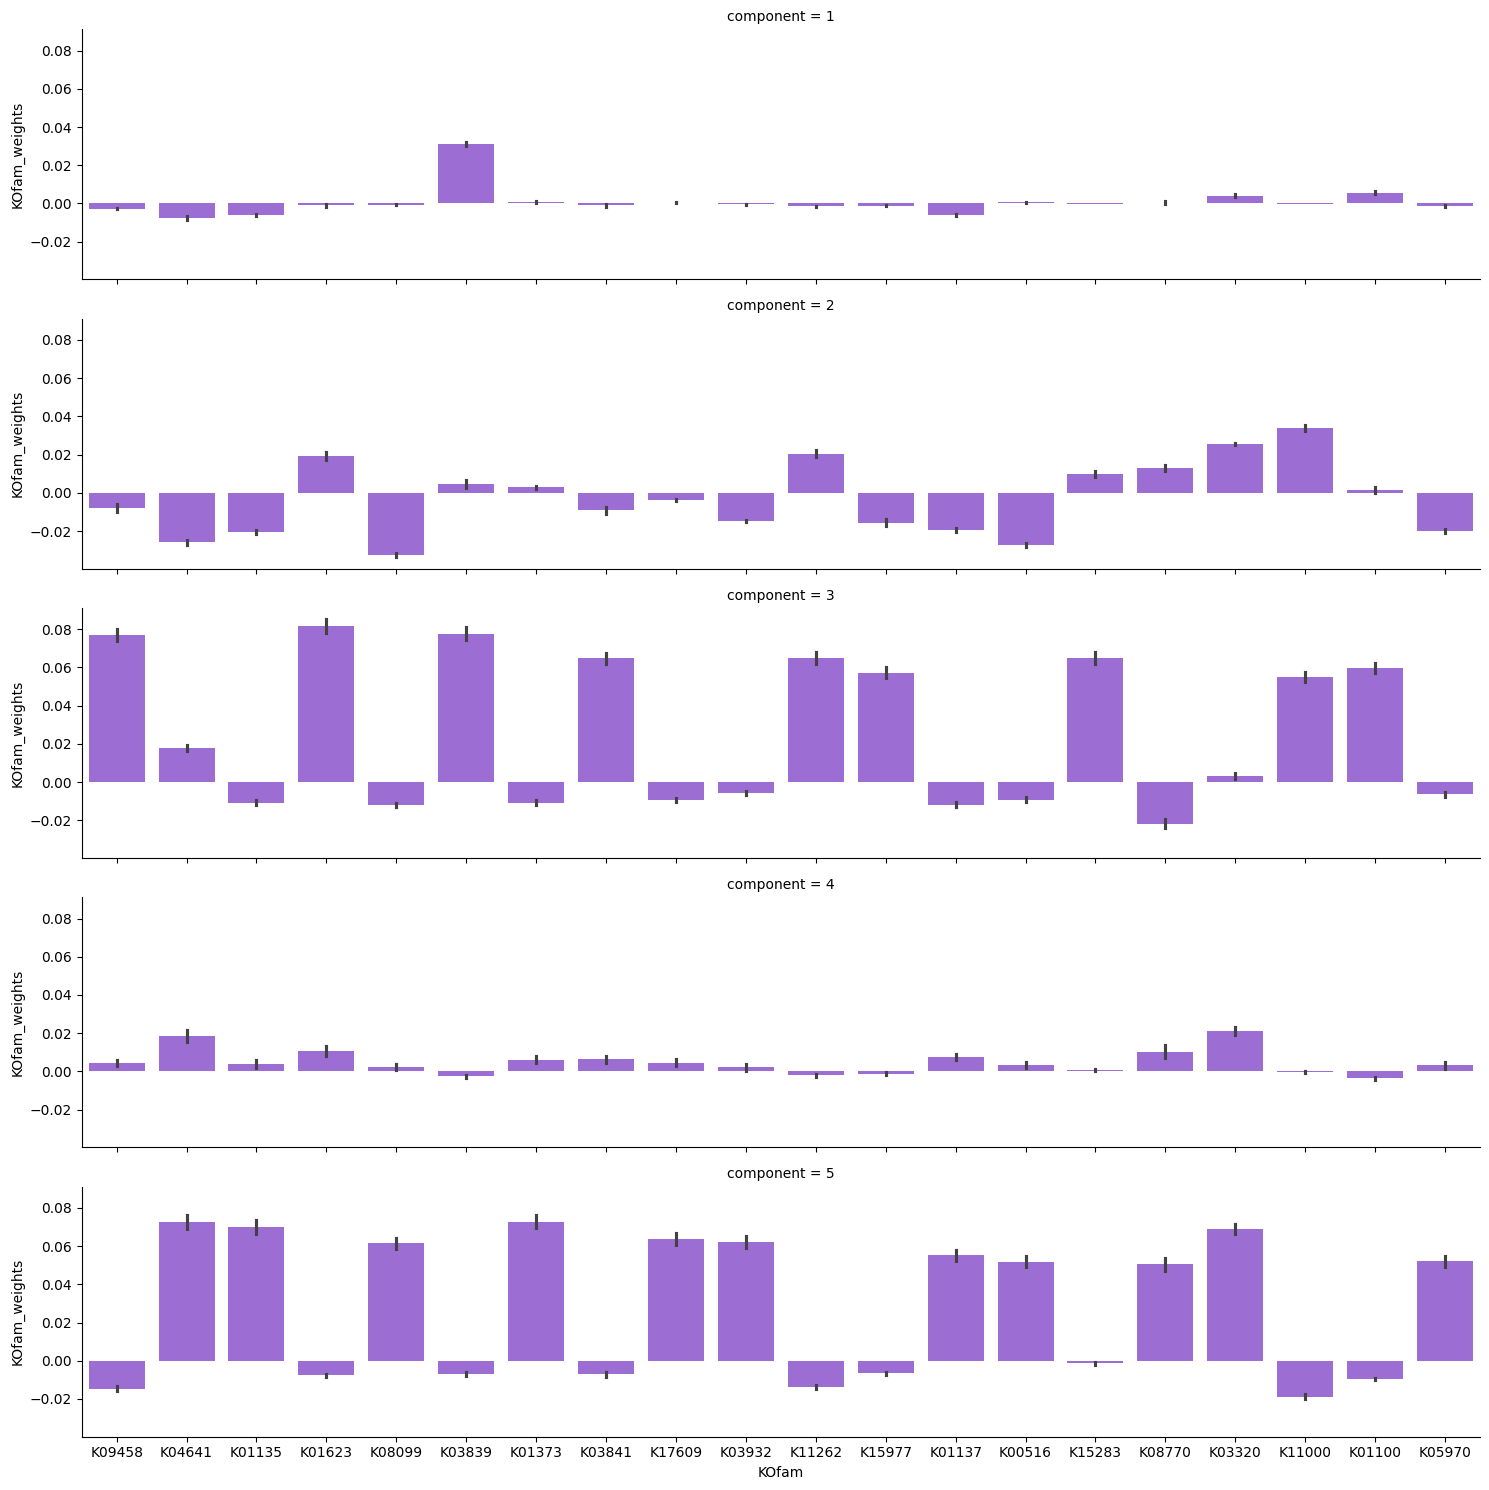

In [6]:
# compare weight vectors between all components

# idx = np.abs(ds.KOfam_weights.median(dim=['bootstrap', 'replicate'])).max(dim='component').argsort() # max weight in any component
idx = ds.KOfam_weights.median(dim=['bootstrap', 'replicate']).std(dim='component').argsort() # biggest spread across components
df = ds.sel(KOfam=ds.KOfam[idx[-20:].data[::-1]]).KOfam_weights.to_series().reset_index()

g = sns.FacetGrid(df, row='component', aspect=5)
# g.map(sns.boxplot, 'KOfam', 'KOfam_weights', order=df.KOfam.unique(), fliersize=1);
g.map(sns.barplot, 'KOfam', 'KOfam_weights', order=df.KOfam.unique());
